In [1]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from sklearn.model_selection import train_test_split
from torch.utils.data import random_split, TensorDataset, DataLoader, Subset
import random
import math
import matplotlib.pyplot as plt
import pandas as pd
import copy
import torchvision.transforms as T


import torch.nn.functional as F
from torchvision import datasets, transforms


In [ ]:
repo_root = Path().resolve().parents[0]   # parent of "notebooks"
sys.path.insert(0, str(repo_root / "src"))

from fisher_information.fim import FisherInformationMatrix
from models.image_classification_models import ConvModelMNIST
from models.train_test import *
from prunning_methods.LTH import *

device = "cuda" if torch.cuda.is_available() else "cpu"

Epoch 1/100- Loss: 0.24388308823108673
Epoch 11/100- Loss: 0.1425311416387558
Epoch 21/100- Loss: 0.10002457350492477
Epoch 31/100- Loss: 0.10860072821378708
Epoch 41/100- Loss: 0.09383159875869751
Epoch 51/100- Loss: 0.03602265939116478
Epoch 61/100- Loss: 0.10217872262001038
Epoch 71/100- Loss: 0.07669588923454285
Epoch 81/100- Loss: 0.018694547936320305
Epoch 91/100- Loss: 0.04629196599125862
RigLScheduler(
layers=3,
nonzero_params=[36/36, 103/1024, 400/4000],
nonzero_percentages=[100.00%, 10.06%, 10.00%],
total_nonzero_params=539/5060 (10.65%),
total_CONV_nonzero_params=139/1060 (13.11%),
step=23500,
num_rigl_steps=176,
ignoring_linear_layers=False,
sparsity_distribution=uniform,
)


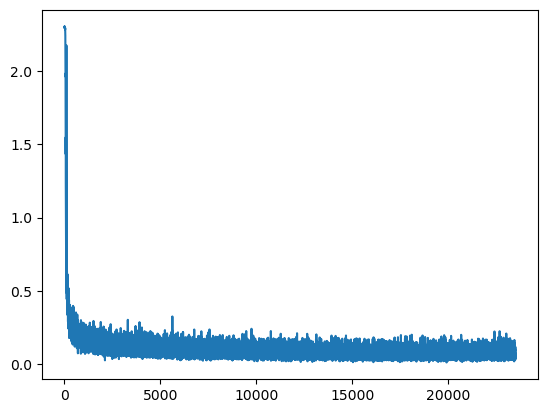

In [3]:
from rigl_torch.RigL import RigLScheduler

# first, create your model
model = ConvModelMNIST().to(device) # note: only tested on torch.hub's resnet networks (ie. resnet18 / resnet50)

# create your dataset/dataloader
mnist_train = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=torchvision.transforms.ToTensor())
mnist_test = torchvision.datasets.MNIST(root='../data', train=False, download=True, transform=torchvision.transforms.ToTensor())

mnist_train_loader = DataLoader(mnist_train, batch_size = 256, shuffle=True)
mnist_train_fim_loader = DataLoader(mnist_train, batch_size = 1, shuffle=True) 
mnist_test_loader = DataLoader(mnist_test, batch_size = 20, shuffle=True)
# define your optimizer (recommended SGD w/ momentum)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)


# RigL runs best when you allow RigL's topology modifications to run for 75% of the total training iterations (batches)
# so, let's calculate T_end according to this
epochs = 100
total_iterations = len(mnist_train_loader) * epochs
T_end = int(0.75 * total_iterations)

# ------------------------------------ REQUIRED LINE # 1 ------------------------------------
# now, create the RigLScheduler object
pruner = RigLScheduler(model,                           # model you created
                       optimizer,                       # optimizer (recommended = SGD w/ momentum)
                       dense_allocation=0.1,            # a float between 0 and 1 that designates how sparse you want the network to be 
                                                          # (0.1 dense_allocation = 90% sparse)
                       sparsity_distribution='uniform', # distribution hyperparam within the paper, currently only supports `uniform`
                       T_end=T_end,                     # T_end hyperparam within the paper (recommended = 75% * total_iterations)
                       delta=100,                       # delta hyperparam within the paper (recommended = 100)
                       alpha=0.3,                       # alpha hyperparam within the paper (recommended = 0.3)
                       grad_accumulation_n=1,           # new hyperparam contribution (not in the paper) 
                                                          # for more information, see the `Contributions Beyond the Paper` section
                       static_topo=False,               # if True, the topology will be frozen, in other words RigL will not do it's job 
                                                          # (for debugging)
                       ignore_linear_layers=False,      # if True, linear layers in the network will be kept fully dense
                       state_dict=None)                 # if you have checkpointing enabled for your training script, you should save 
                                                          # `pruner.state_dict()` and when resuming pass the loaded `state_dict` into 
                                                          # the pruner constructor
# -------------------------------------------------------------------------------------------

#... more code ...
loss_list = []
criterion = nn.CrossEntropyLoss()
for epoch in range(epochs):
    for X, y in mnist_train_loader:
        # do forward pass, calculate loss, etc.
        optimizer.zero_grad()
        X = X.to(device)
        y = y.to(device)
        out = model.forward(X)
        loss = criterion(out, y)
        loss_list.append(loss.item())
        loss.backward()


        # instead of calling optimizer.step(), wrap it as such:

# ------------------------------------ REQUIRED LINE # 2 ------------------------------------
        if pruner():
# -------------------------------------------------------------------------------------------
            # this block of code will execute according to the given hyperparameter schedule
            # in other words, optimizer.step() is not called after a RigL step
            optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}- Loss: {loss.item()}")
    # it is also recommended that after every epoch you checkpoint your training progress
    # to do so with RigL training you should also save the pruner object state_dict
    # torch.save({
    #     'model': model.state_dict(),
    #     'pruner': pruner.state_dict(),
    #     'optimizer': optimizer.state_dict()
    # }, 'checkpoint.pth')

plt.plot(loss_list)
# at any time you can print the RigLScheduler object and it will show you the sparsity distributions, number of training steps/rigl steps, etc!
print(pruner)

# save model
torch.save(model.state_dict(), 'model.pth')

In [4]:
test(model, mnist_test_loader)

0.9786

In [5]:
fim = FisherInformationMatrix(model, criterion, optimizer, mnist_train_fim_loader)

In [6]:
fim.logdet_ratio

1041.1015625

In [9]:
fim.diaglogdet

-85988.4140625